In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from emcee import EnsembleSampler
from chainconsumer import ChainConsumer, Chain

In [11]:
alldata1 = pd.DataFrame({
    'Age': [45, 25, 45, 15, 50, 48, 52, 58, 10, 62, 28, 62, 18, 57, 37, 47, 22, 69, 43, 73],
    'Income': [30, 50, 40, 70, 35, 32, 55, 45, 75, 28, 60, 42, 80, 30, 58, 40, 72, 31, 53, 41],
    'Years_Insured': [2, 10, 5, 15, 3, 2, 8, 4, 12, 1, 9, 3, 14, 2, 11, 4, 13, 2, 10, 3],
    'Claims': [1, 3, 2, 5, 0, 1, 2, 1, 4, 0, 3, 1, 4, 0, 3, 2, 4, 1, 2, 1]
})

/Users/yordani/Documents/learning_ml/ml_venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yordani/Documents/learning_ml/ml_venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yordani/Documents/learning_ml/ml_venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yordani/Documents/learning_ml/ml_venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWar

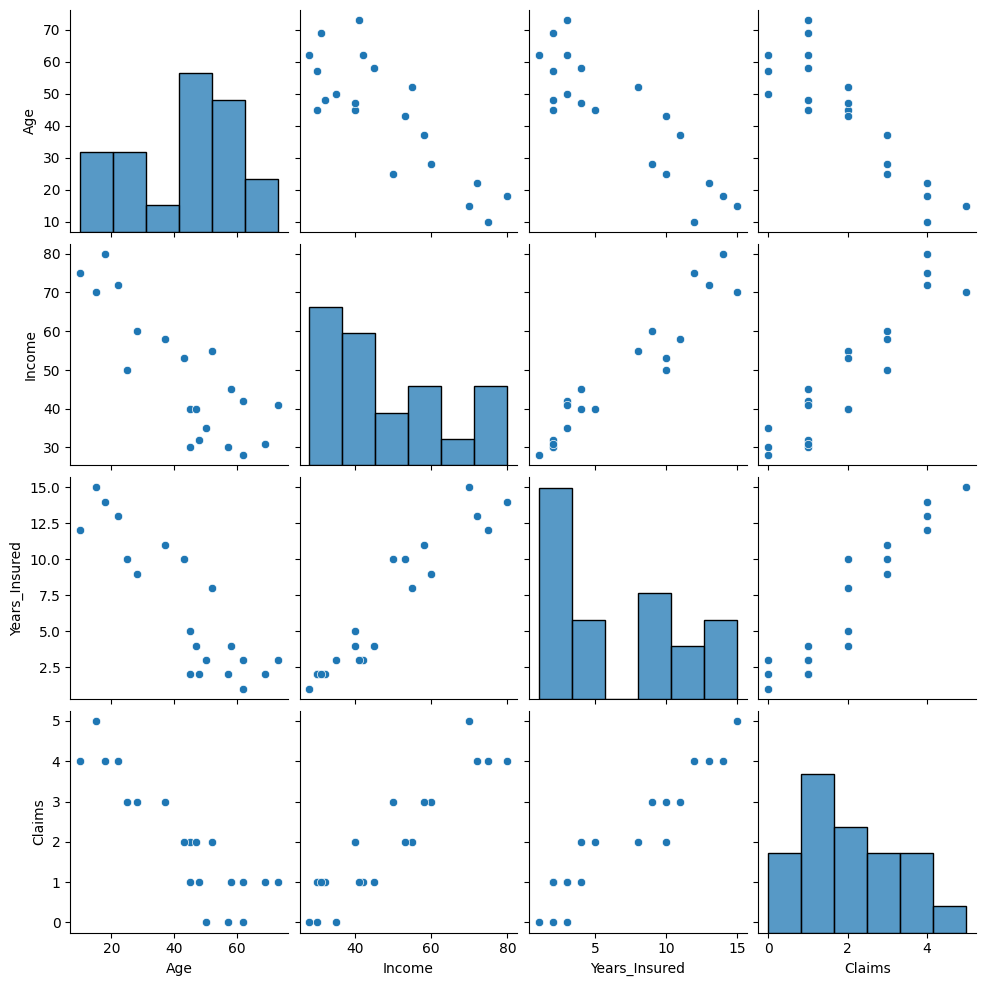

In [12]:
sns.pairplot(alldata1)

Let's assume that the likelihood is Poisson, e.g. the probability that the number of claims is $y$ is distributed according to

$$
y \sim \frac{\mu^y \exp{(-\mu)}}{\mu!} \,.
$$

We choose a log link function - $\log\mu = \beta_0 + \beta_1 \mathrm{Age} + \beta_2 \mathrm{Income} + \beta_3 \mathrm{Years Insured} = X \beta$. This means the possibility that the nonsensical $\mu<0$ output will not occur. IRL, we probably expect the factors to correlate logarithmically with claims mean, so an exponential link is sensible (even if the data here does actually look more linear!).

So we now have the data $\{y_i,\mathbf{x}_i\}$, and the likelihood function:
$$
L(\mathbf{y}|\beta) = \prod_{i=1}^{N_{data}} \frac{\mu_i^{y_i} \exp{(-\mu_i)}}{y_i!}
$$
for
$$\log\mu = \eta = \beta_0 + \beta_1 \mathrm{Age} + \beta_2 \mathrm{Income} + \beta_3 \mathrm{Years Insured} = X \beta$$


Should check that a Poisson model would work here:

In [13]:
print("Mean num claims =",alldata1['Claims'].mean())
print("var num claims =",alldata1['Claims'].var())

Mean num claims = 2.0
var num claims = 2.210526315789474


In [20]:
from scipy.special import factorial
def loglike(betas: np.array, data: np.array, target: np.array):
    eta = data @ betas
    mean = np.exp(eta)
    like = np.sum(target * eta - mean - factorial(target))
    return like

def eval(betas: np.array, data: np.array):
    eta = data @ betas
    return np.exp(eta)

def preprocess_GLM(raw_data, target_name='Claims'):
    """
    Take the raw data array, returning the target column as
    a numpy array, and the rest of the data as a 2D array
    with columns corresponding to the data variables.
    """
    all_data = pd.DataFrame(raw_data)
    num_claims = all_data.pop(target_name).to_numpy(dtype=int)
    var_names = all_data.columns
    all_data.insert(0, 'ones', 1.)
    
    return num_claims, all_data.to_numpy(), var_names
    

Text(0, 0.5, 'Claim mean')

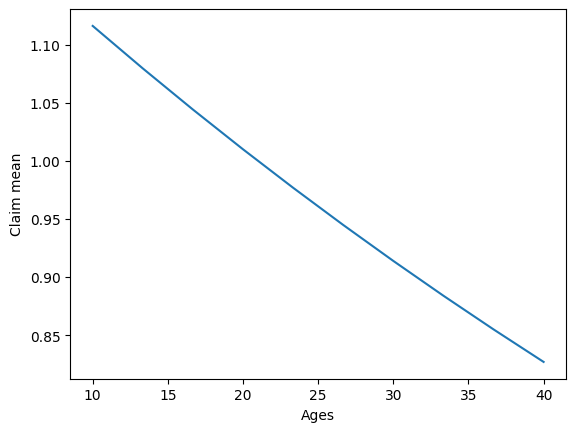

In [21]:
# Sanity-check the model.
age_arr = np.linspace(10,40,10)
betas = np.array([0.01,-0.01,0.01,0.01])
claim_means = [eval(betas,np.array([1,age,10,10])) for age in age_arr]
plt.plot(age_arr, claim_means)
plt.xlabel("Ages")
plt.ylabel("Claim mean")

In [22]:
# Preprocess the data (in this case just pop out the claims column) and run 
# MCMC to fit the model to the data.
num_claims, data, var_names = preprocess_GLM(alldata1)

nwalkers = 32
ndim     = len(var_names)+1
steps    = 10000
p0       = np.array([0.01, 0.01, 0.01, 0.01])
pos      = p0*(1 + 1e-4*np.random.randn(nwalkers, ndim))

sampler  = EnsembleSampler(
    nwalkers, 
    ndim, 
    loglike, 
    args=(data, num_claims)
)
_=sampler.run_mcmc(pos, nsteps=steps, progress=True)
chain_mcmc = sampler.get_chain(flat=True, discard=5000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.85it/s]


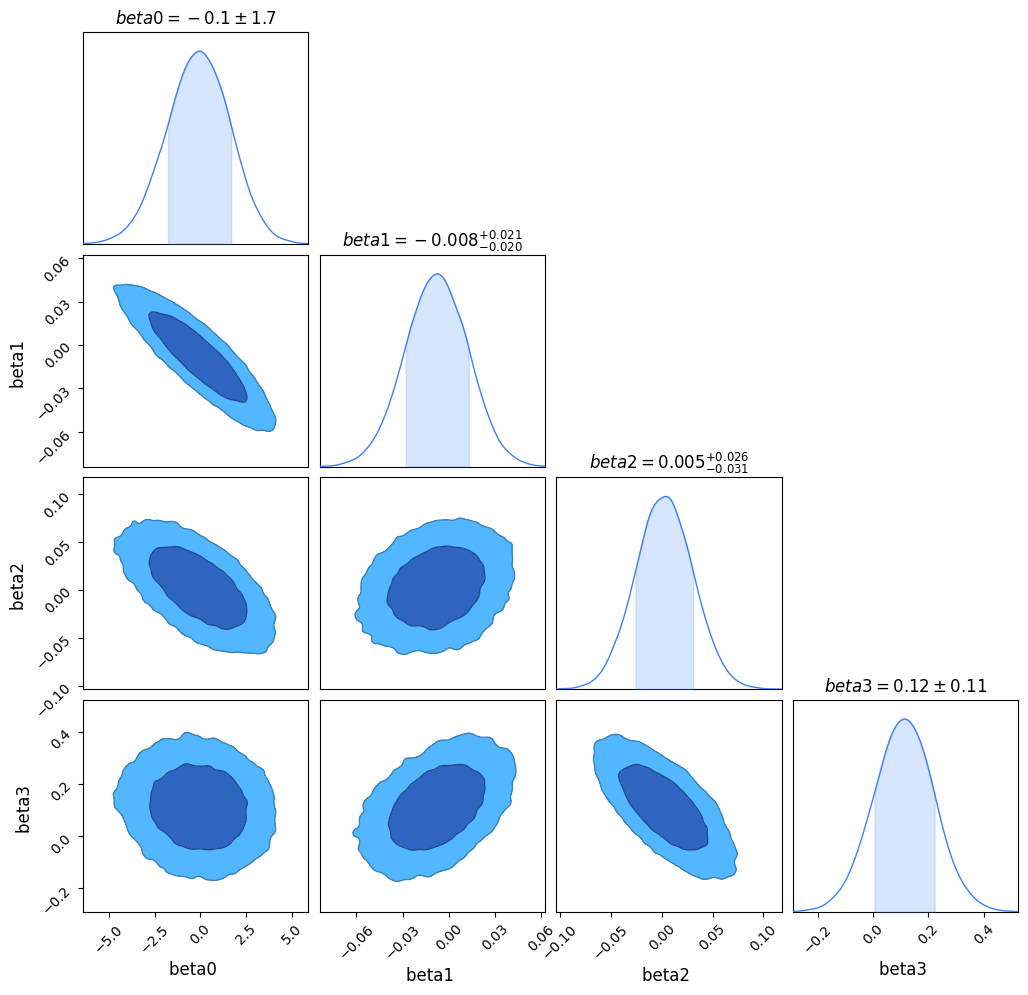

In [23]:
c=ChainConsumer()
chain_df = pd.DataFrame(chain_mcmc, columns=['beta0','beta1','beta2','beta3'])
c.add_chain(Chain(samples=chain_df, name="An Example Contour"))
f=c.plotter.plot()


In [24]:
mean_beta=np.mean(chain_mcmc,axis=0)
print(mean_beta)

[-0.11694293 -0.00801793  0.00267295  0.11132411]


/Users/yordani/Documents/learning_ml/ml_venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yordani/Documents/learning_ml/ml_venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/yordani/Documents/learning_ml/ml_venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/yordani/

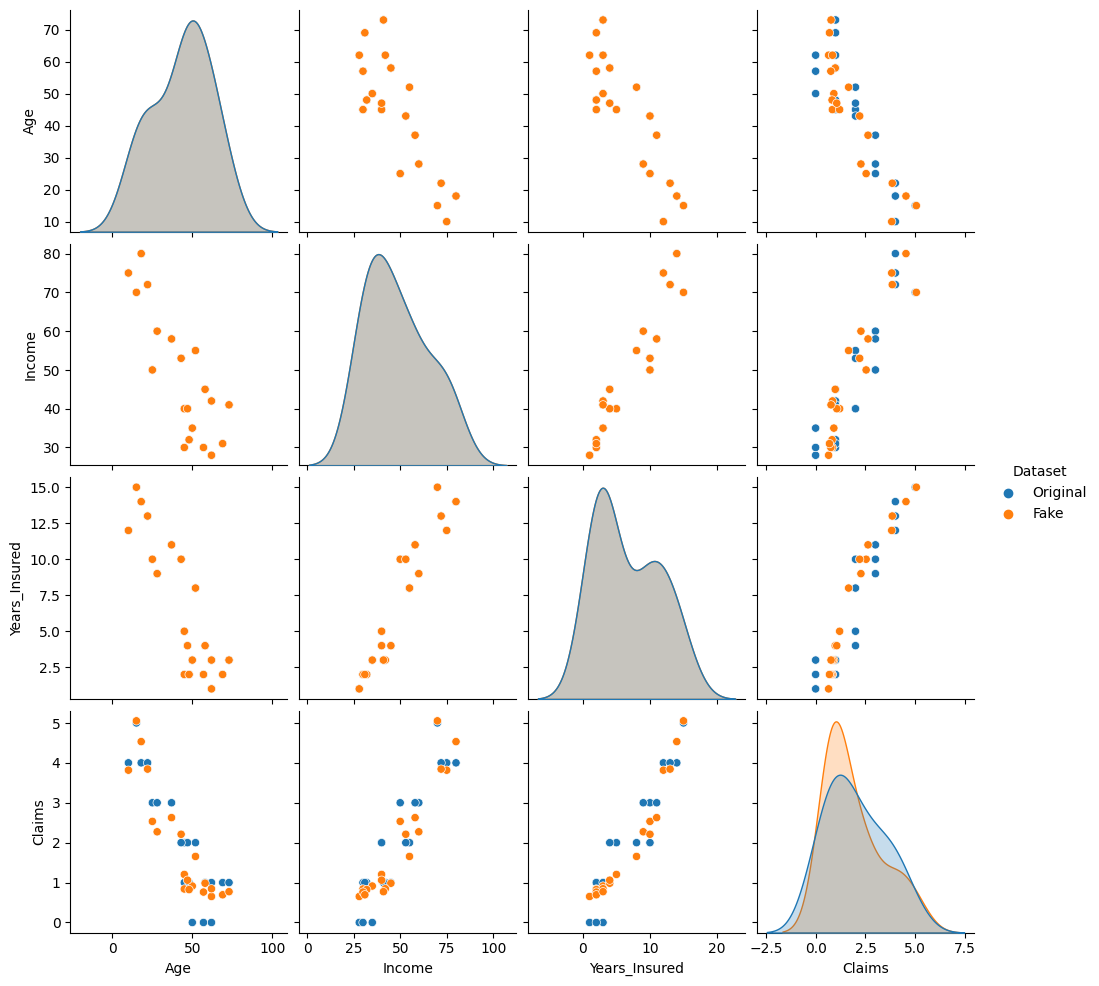

In [26]:
fake_data = pd.DataFrame({
    'Age': [45, 25, 45, 15, 50, 48, 52, 58, 10, 62, 28, 62, 18, 57, 37, 47, 22, 69, 43, 73],
    'Income': [30, 50, 40, 70, 35, 32, 55, 45, 75, 28, 60, 42, 80, 30, 58, 40, 72, 31, 53, 41],
    'Years_Insured': [2, 10, 5, 15, 3, 2, 8, 4, 12, 1, 9, 3, 14, 2, 11, 4, 13, 2, 10, 3],
    'Claims': eval(mean_beta, data)
})
original_data = pd.DataFrame(alldata1)
original_data['Dataset'] = 'Original'
fake_data['Dataset']     = 'Fake'

# Concatenate the DataFrames
combined_df = pd.concat([original_data, fake_data], ignore_index=True)

# Create the pairplot with hue
sns.pairplot(combined_df, hue='Dataset')
plt.show()

Here we're testing the model using the training data, which isn't best practice, but it does look like things line up well and that they're generally working.

Looking at the posteriors, they're not super well constrained. Adding more data will alleviate this.

We could come up with some metric to evaluate continually how well the model is doing - some distance between claim prediction and actual claim number. If we find that over time the model begins doing worse, it should probably be re-trained on new data. 

For a model with a much larger parameter space than this one, finding the optimal region is quite difficult, so a good way is to perform a Bayesian update instead of re-training on the new combined dataset. This will automatically encode the knowledge the model has gained in the first training step.

There is one thing that's kind of annoying - claims = 0 isn't being predicted. This is a feature of the poisson model. You could always set a threshold for eta such that below this the model will predict mean zero, but the poisson likelihood would then involve taking the logarithm of zero.